In [ ]:
'''
Example : An Access-Control Queuing Task This is a decision task involving access control to a set of 10 servers. Customers of four di↵erent priorities arrive at a single queue. If given access to a server, the customers pay a reward of 1, 2, 4, or 8 to the server, depending on their priority, with higher priority customers paying more. In each time step, the customer at the head of the queue is either accepted (assigned to one of the servers) or rejected (removed from the queue, with a reward of zero). In either case, on the next time step the next customer in the queue is considered. The queue never empties, and the priorities of the customers in the queue are equally randomly distributed. Of course a customer cannot be served if there is no free server; the customer is always rejected in this case. Each busy server becomes free with probability p = 0.06 on each time step. Although we have just described them for definiteness, let us assume the statistics of arrivals and departures are unknown. The task is to decide on each step whether to accept or reject the next customer, on the basis of his priority and the number of free servers, so as to maximize long-term reward without discounting.
In this example we consider a tabular solution to this problem. Although there is no generalization between states, we can still consider it in the general function approximation setting as this setting generalizes the tabular setting. Thus we have a di↵erential action- value estimate for each pair of state (number of free servers and priority of the customer at the head of the queue) and action (accept or reject). Figure 10.5 shows the solution found by di↵erential semi-gradient Sarsa with parameters ↵ = 0.01,   = 0.01, and " = 0.1. The initial action values and R ̄ were zero.
'''

In [1]:
import numpy as np
import time
import sys
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
from tilecoding import *

In [2]:
#State = [Number of Free Servers, Priority of Customer at head of que]

#Accept - 0
#Reject -1 
#ACTIONS = [1,0]
          #H    #L
#Queue - [ 0 0 0 0 ]

In [3]:
ACTIONS = [1,0]
Number_Of_Servers = 10

In [4]:
class ValueFunction:

    def __init__(self,number_of_tiles = 8,max_size = 2048):

        self.number_of_tiles = number_of_tiles

        self.max_size = max_size

        self.hashable = IHT(self.max_size)

        self.weights = np.zeros(self.max_size)

        self.Free_Server_Scale = self.number_of_tiles/ 10
        self.Customer_Priority_Scale = self.number_of_tiles/3

    def get_active_tiles(self,state,action):

        active_tiles = tiles(self.hashable,self.number_of_tiles,[state[0]*self.Free_Server_Scale,state[1]*self.Customer_Priority_Scale],[action])

        return active_tiles

    def value(self,state,action):

        active_tiles = self.get_active_tiles(state,action)

        value = np.sum(self.weights[active_tiles])

        return value

    def Update(self,state,action,delta,alpha):

        active_tiles = self.get_active_tiles(state,action)        

        for active_tile in active_tiles:
            self.weights[active_tile] += alpha*delta         

    def stateValue(self, state):
        if state[0] == 0:
            #no server available
            return self.value(state, 0)
        values = [self.value(state, a) for a in ACTIONS]
        return max(values)
    

    def Return_Weights(self):

        return self.weights

In [5]:
class Server:

    def __init__(self):

        self.Average_Reward = 0
        self.Number_Of_Servers = 10
        self.Customer_List = [8,4,2,1]
        self.Quene = []

        self.alpha = 0.01
        self.beta = 0.01
        self.eps = 0.1
        # self.Free_Servers = 0

    def reset(self):
        self.Quene = []
        #Servers at Start
        Free_Servers = np.random.randint(1,11)

        #Random Customer Quene 

        for custo in range(len(self.Customer_List)):
            a = np.random.choice(self.Customer_List)
            self.Quene.append(a)

        #Return Number Of Start Servers and Random Quene of Servers
        
        state = (Free_Servers,self.Quene[0])
        return state

    #Accept - 0
    #Reject - 1 

    def FreeUpServers(self,Free_Servers):

        Busy_Servers = self.Number_Of_Servers - Free_Servers

        for x in range(Busy_Servers):

            p = np.random.rand()

            if p < 0.06:
                Free_Servers +=1
        
        return Free_Servers
    

    def get_action(self,state,valueFun):

        p = np.random.rand()

        if p<self.eps:
            action = np.random.choice(ACTIONS)
            return action

        values = {}

        for a in ACTIONS:

            value = valueFun.value(state,a)
            values[a] = value

        max_action = max(values,key = values.get)

        return max_action

    def step(self,state,action):

        Free_Servers = state[0]
        First_Customer = state[1]

        if action == 0 and Free_Servers>0:
            Free_Servers = Free_Servers - 1
            reward = First_Customer

        else:
            reward = 0

        #Randomly Free Up Servers
        Next_Free_Servers = self.FreeUpServers(Free_Servers)

        Next_Quene = []

        for i in range(len(self.Quene)):

            if i!=len(self.Quene)-1:
                Next_Quene.append(self.Quene[i+1])
            else:
                Next_Quene.append(np.random.choice(self.Customer_List))

        self.Quene = Next_Quene

        next_state = (Next_Free_Servers,self.Quene[0])

        return next_state,reward

    def Diffrential_Semi_Gradient_Sarsa(self,valueFun,episode_len = 1):

        for x in range(episode_len):

            print("Predicting State Values: {:.5f}".format(x), end="\r")

            count = 0 

            state = self.reset()
            action = self.get_action(state,valueFun)

            while count!= 5000:

                next_state,reward = self.step(state,action)

                next_action = self.get_action(next_state,valueFun)

                delta = reward - self.Average_Reward + valueFun.value(next_state,next_action) - valueFun.value(state,action)
                self.Average_Reward += self.beta*delta 
                valueFun.Update(state,action,delta,self.alpha)

                state = next_state
                action = next_action

                count+=1


In [6]:
vf = ValueFunction()

In [7]:
s = Server()

In [8]:
s.Diffrential_Semi_Gradient_Sarsa(vf,episode_len = 100)

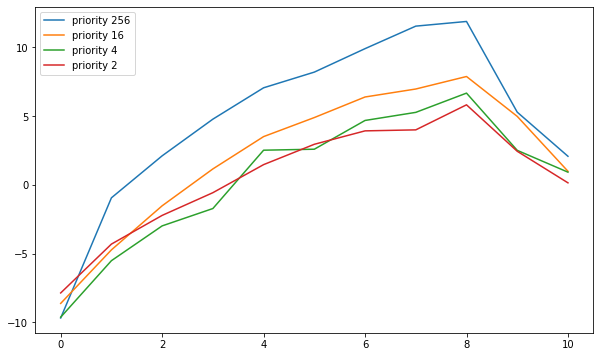

In [9]:
plt.figure(figsize=[10, 6])

for prioriy in s.Customer_List:
    n_servers = []
    values = []
    for n_server in range(11):
        state = (n_server, prioriy)
        value = vf.stateValue(state)
        n_servers.append(n_server)
        values.append(value)
    plt.plot(n_servers, values, label="priority {}".format(np.power(2, prioriy)))
plt.legend()
plt.show()